# Classification with python

In this notebook, we will try to build a classifier to predict whether a loan case will be paid off or not.  
Therfore, we will use 4 algortihms to build this models:  
        - K-Nearest Neighbors  
        - Decision tree  
        - Support Vector Machine  
        - Logistic Regression    
Then, we will compare these 4 models by comparing their accuracy, using these metrics:  
        - Jaccard Index  
        - F1-score  
        - LogLoss (for the Logistic Regression model)  

### 1. Loading required libraries

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

### 2. Loading the data from a CSV file:

First, we start by loading the training data.

In [2]:
df=pd.read_csv('../data/loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

Now, we will drop useless columns

In [ ]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [6]:
df.dtypes

loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### 3. Data vizualization:

Let's vizualize our data to understand it better.

We start by countig how many of each class is in our data set

In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

We notice that 260 peaople have paid their loan while 86 others have gone into collection.

Now, we will plot some columns to understand the data better.  
We start by vizualizing the number of people in each class based on their principal and gender.

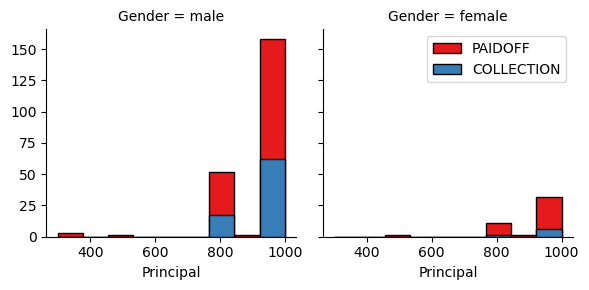

In [12]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Then, we replace the principal column by the age one.

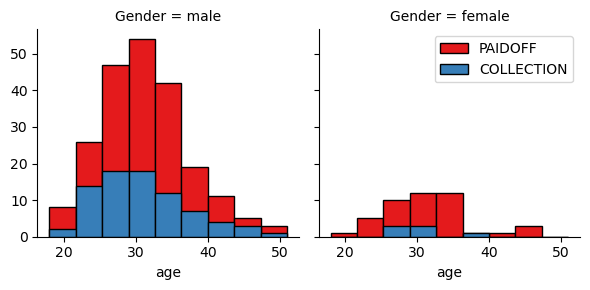

In [13]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [18]:
df['effective_date'] = pd.to_datetime(df['effective_date'])

But, which day of the week people get a loan the most? Let's look at that.

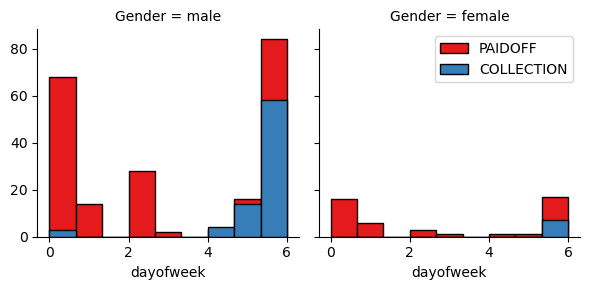

In [19]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### 4. Data pre-processing:

Now, we should make a data pre-processing to transform our raw data into useful and efficient format.

We notice that "effective_date" end "due date" aren't in the date time object type. Let's convert them this type.

In [21]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4


In [22]:
df.dtypes

loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dayofweek                  int64
dtype: object

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4.

In [23]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


#### Converting categorical features to numerical values:

We notice that there are some features which contain numerical values. Let's convert them!

We convert male to 0 and female to 1.

In [24]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


To convert education feature, we use the one hot encoding technique.

In [25]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### 5. Feature selection:

We define the feature set X.

In [26]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


Now, it's time for labels.

In [27]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### 6. Data Normalization:

We normalize our data by giving it zero mean anad unit variation.

In [28]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

### 7. Building the model:

Our data is ready now! Let's start building the model.

#### K Nearest Neighbor(KNN):

We start by importing the ibraries.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

Before we build the model, we should find the best K that lead to the best accuracy. Therfore, we will split our train_loan.csv into train and test to find the best k.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=4)
Ks=10
acc=np.zeros(Ks)
for i in range (1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    acc[i-1]=metrics.accuracy_score(y_test,yhat)
print("the best accuracy is :",acc.max(),"with k =",acc.argmax()+1)

the best accuracy is : 0.7857142857142857 with k = 7


Now, we can build our model.

In [31]:
K=7
neigh=KNeighborsClassifier(n_neighbors=K)
neigh.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

We calculate the train set accuracy.

In [32]:
accu1 = metrics.accuracy_score(y,neigh.predict(X))
print("The train test accuracy is ",accu1)

The train test accuracy is  0.8005780346820809


#### Decision Tree:

We start by importing the ibrary that we need.

In [33]:
from sklearn.tree import DecisionTreeClassifier

We build the model and then we calculate the accuracy.

In [34]:
tree = DecisionTreeClassifier()
tree.fit(X,y)

DecisionTreeClassifier()

In [35]:
accu2 = metrics.accuracy_score(y,tree.predict(X))
print("The train test accuracy is ",accu2)

The train test accuracy is  0.8930635838150289


In the two remaining algorthims, we will follow the same steps.

#### Support Vector Machine:

In [36]:
from sklearn import svm

In [37]:
SVectM = svm.SVC()
SVectM.fit(X,y)

SVC()

In [34]:
accu3 = metrics.accuracy_score(y,SVectM.predict(X))
print("The train test accuracy is ",accu3)

The train test accuracy is  0.7601156069364162


#### Logistic Regression:

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
LR = LogisticRegression(C=0.005)
LR.fit(X,y)

LogisticRegression(C=0.005)

In [38]:
accu4 = metrics.accuracy_score(y,LR.predict(X))
print("The train test accuracy is ",accu4)

The train test accuracy is  0.7514450867052023


### 8. Model evaluation:

After building the model, we will evaluate them using the loan_test data.

#### Importing the required libraries:

In [40]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

#### Loading the test set:

In [40]:
test_df = pd.read_csv('../data/loan_test.csv')
test_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


#### Test set pre-processing:

We notice that the test set has the same structure as the train one. So, we will follow the same pre-processing steps.

In [41]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
FeatureTest = test_df[['Principal','terms','age','Gender','weekend']]
FeatureTest = pd.concat([FeatureTest,pd.get_dummies(test_df['education'])], axis=1)

#### Extracting features and normalizing data:

In [42]:
X_testSet = FeatureTest
X_testSet= preprocessing.StandardScaler().fit(X_testSet).transform(X_testSet)
y_testSet = test_df['loan_status'].values

Now, we will evaluate the accuracy of each model.

##### KNN evaluation:

We start by making predictions with test set.

In [43]:
yhat1 = neigh.predict(X_testSet)
print(yhat1)

['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF']


Then, we evaluate the accuracy of this model.

In [46]:
from sklearn.metrics import f1_score, jaccard_score
print("The Jaccard index is" ,jaccard_score(y_testSet, yhat1, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))
print("The F1_score is" ,f1_score(y_testSet, yhat1, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))

The Jaccard index is 0.7
The F1_score is 0.823529411764706


In the two remaining algorthims, we will follow the same steps.

##### Tree Decision evaluation:

In [47]:
yhat2 = tree.predict(X_testSet)
print(yhat2)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF']


In [48]:
print("The Jaccard index is" ,jaccard_score(y_testSet, yhat2, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))
print("The F1_score is" ,f1_score(y_testSet, yhat2, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))

The Jaccard index is 0.6458333333333334
The F1_score is 0.7848101265822786


##### Support Vector Machine evaluation:

In [49]:
yhat3 = SVectM.predict(X_testSet)
print(yhat3)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [50]:
print("The Jaccard index is" ,jaccard_score(y_testSet, yhat3, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))
print("The F1_score is" ,f1_score(y_testSet, yhat3, labels=['PAIDOFF','COLLECTION'], pos_label='PAIDOFF'))

The Jaccard index is 0.7222222222222222
The F1_score is 0.8387096774193549
